In [ ]:
import pandas as pd
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, LinearRegression
import numpy as np
from pathlib import Path
import operator
from math import sqrt
from statistics import mean
import pickle
import warnings
from sklearn.metrics import r2_score
from sklearn import linear_model
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [246]:
y_pred = [] 
y_true = []
class Learner:
    ml_model = None
    dataset = None
    X = None
    y = None
    enc = None 

    def set_encoder(self, file):
        tmp = pd.read_csv(file)
        tmp = tmp.drop(columns=['Price'])
        self.enc = pd.get_dummies(tmp).columns

    def train_and_predict(self, file, brand, model, kms, license, year, capacity, type_):
        if(self.preprocess(file, brand, model)==-1):
          return -1
        self.learn()
        return self.predict(brand, model, kms, license, year, capacity, type_)

    def preprocess(self, file, brand, model):
        self.dataset = pd.read_csv(file)
        self.dataset = self.dataset.fillna(0)
        if(len(self.dataset)==0):
          return -1
        self.y = self.dataset['Price'].copy()
        self.X = self.dataset.drop(columns=['Price']).copy()
        self.X = pd.get_dummies(self.X)
        for i in self.enc:
            if i not in self.X:
                self.X[i] = 0
        
        self.X = self.X.reindex(sorted(self.X.columns), axis=1)

    def learn(self):
        self.ml_model = LinearRegression()
        self.ml_model.fit(self.X, self.y)
        # save the model to disk
        #filename = 'finalized_model.sav'
        #pickle.dump(self.ml_model, open(filename, 'wb'))

        return self.ml_model

    def predict(self, brand, model, kms, license, year, capacity, type_):
        dt = pd.DataFrame.from_dict({'Kms': [kms], 'License': [license], 'Year': [year], 'Capacity': [capacity],
                                       'Type': [type_], 'Brand': [brand], 'Model':[model]})
        dt = pd.get_dummies(dt)
        for i in self.enc:
            if i not in dt:
                dt[i] = 0
        dt = dt.reindex(sorted(dt.columns), axis=1)
        val = self.ml_model.predict(dt)[0]
        #return self.ml_model.predict(dt)[0]
        return "{0:.3f}".format(val)
    
    def score(self):
        df = pd.read_csv('motoDatasetFinal.csv')
        df.fillna(0)
        y = df['Price'].copy()
        X = df.drop(columns=['Price']).copy()
        self.X = df.drop(columns=['Price']).copy()
                
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1, random_state=6)

        for row, col in X_test.iterrows():
            try:
              if (len(col)==7):
                pred = self.train_and_predict('motoDatasetFinal.csv', col['Brand'], col['Model'], col['Kms'], col['License'], col['Year'],
                                          col['Capacity'], col['Type'])
                if(pred!=-1):
                  y_pred.append(pred)
                  y_true.append(y_test[row])
            except ValueError:
              continue

        score = r2_score(y_true, y_pred)
        y
        print(score)
        return score

In [247]:
learner = Learner()
learner.set_encoder('motoDatasetFinal.csv')
learner.score()

0.8441849662388969


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)


0.8441849662388969

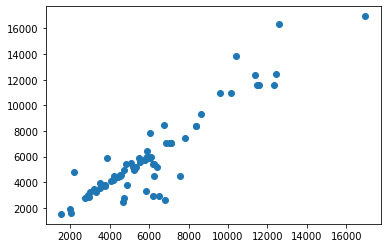

In [250]:
from numpy.ma.core import std
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
import numpy as np
y_pred_n = np.array(y_pred, dtype=float)
y_true_n = np.array(y_true, dtype=float)

plt.scatter(y_pred_n,y_true_n)
plt.show()